# **tSDRG Data Analysis**

### 1. **Before start plotting, please change the file path "my_metadata_file = ..." to your own metadata directory.**
### &emsp;*By defalt is for dropbox path.*
### 2. **Dim / Jdis = Dimerization / Randomness strength** 

### 3. **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### &emsp;*example: Dim123 = Dimerization 1.23*

# **Define metadata directory path**

In [1]:
## ------------------------------------------ Please change blow path to your own metadata directory path ------------------------------------------
my_metadata_file = '../tSDRG_metadata/Spin2/metadata/' ## Your local path (not necessary)
# my_metadata_file = './Spin2_metadata/' ## Defalt

# **Import lib and set basic parameter**

In [2]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [3]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkorange':           '#FF8C00',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', '^-', 'x-', 's-', 'p-', '*-', 'h-']   ## marker array
marr_nl = ['o', '^', 'x', 's', 'p', '*', 'h']       ## marker array (no line)

spin = int(2)                                       ## Spin type
BC = 'PBC'                                          ## Boundary condition
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 40                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim000 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 600   ## Jdis600 = 6.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis600]

# **Define function**

In [4]:
def find_id(f_diff, skip_L): ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)

    if (len(ids) != 1):
        skip_L = True
        # if (len(ids) == 0):
        #     print("no crossing point")
        # else:
        #     print("too many crossing point")
    return ids, skip_L

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x = (b2-b1)/(a1-a2)
    return x

def fitting_point_second(f_L1, f_L2, ids, var, para, L_n_point, R_n_point): ## use second-degree polynomial to fit curve
    for id in ids:   
        id_range = range(id-L_n_point, id+R_n_point) ## use R_n_point - L_n_point to fit

        a1, b1, c1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 2)
        a2, b2, c2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 2)
        a = a1-a2 
        b = b1-b2
        c = c1-c2
        x1 = (-b + (b**2 - 4*a*c)**0.5)/(2*a)
        x2 = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    return x1, x2
    
def fitting_point_slope(f_L1, f_L2, ids, var, para, n_point): ## return L1, L2 slope
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
    return a1, a2

def find_id_2(f_L, skip_L): ## find the index that sign changed
    ids = []
    for id in range(len(f_L)-1):
        if (np.sign(f_L['ZL'][id]) != np.sign(f_L['ZL'][id+1])):
            ids.append(id)

    if (len(ids) != 1):
        skip_L = True
        # if (len(ids) == 0):
        #     print("no crossing point")
        # else:
        #     print("too many crossing point")
    return ids, skip_L

def fitting_point_2(f_L, ids, var, para, n_point):
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n-1 point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a, b = np.polyfit(f_L[var][id_range], f_L[para][id_range], 1)
        x = -b/a
    return x

# **Plot**

## Fix **<font color = yellow>J</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = green>D</font>**

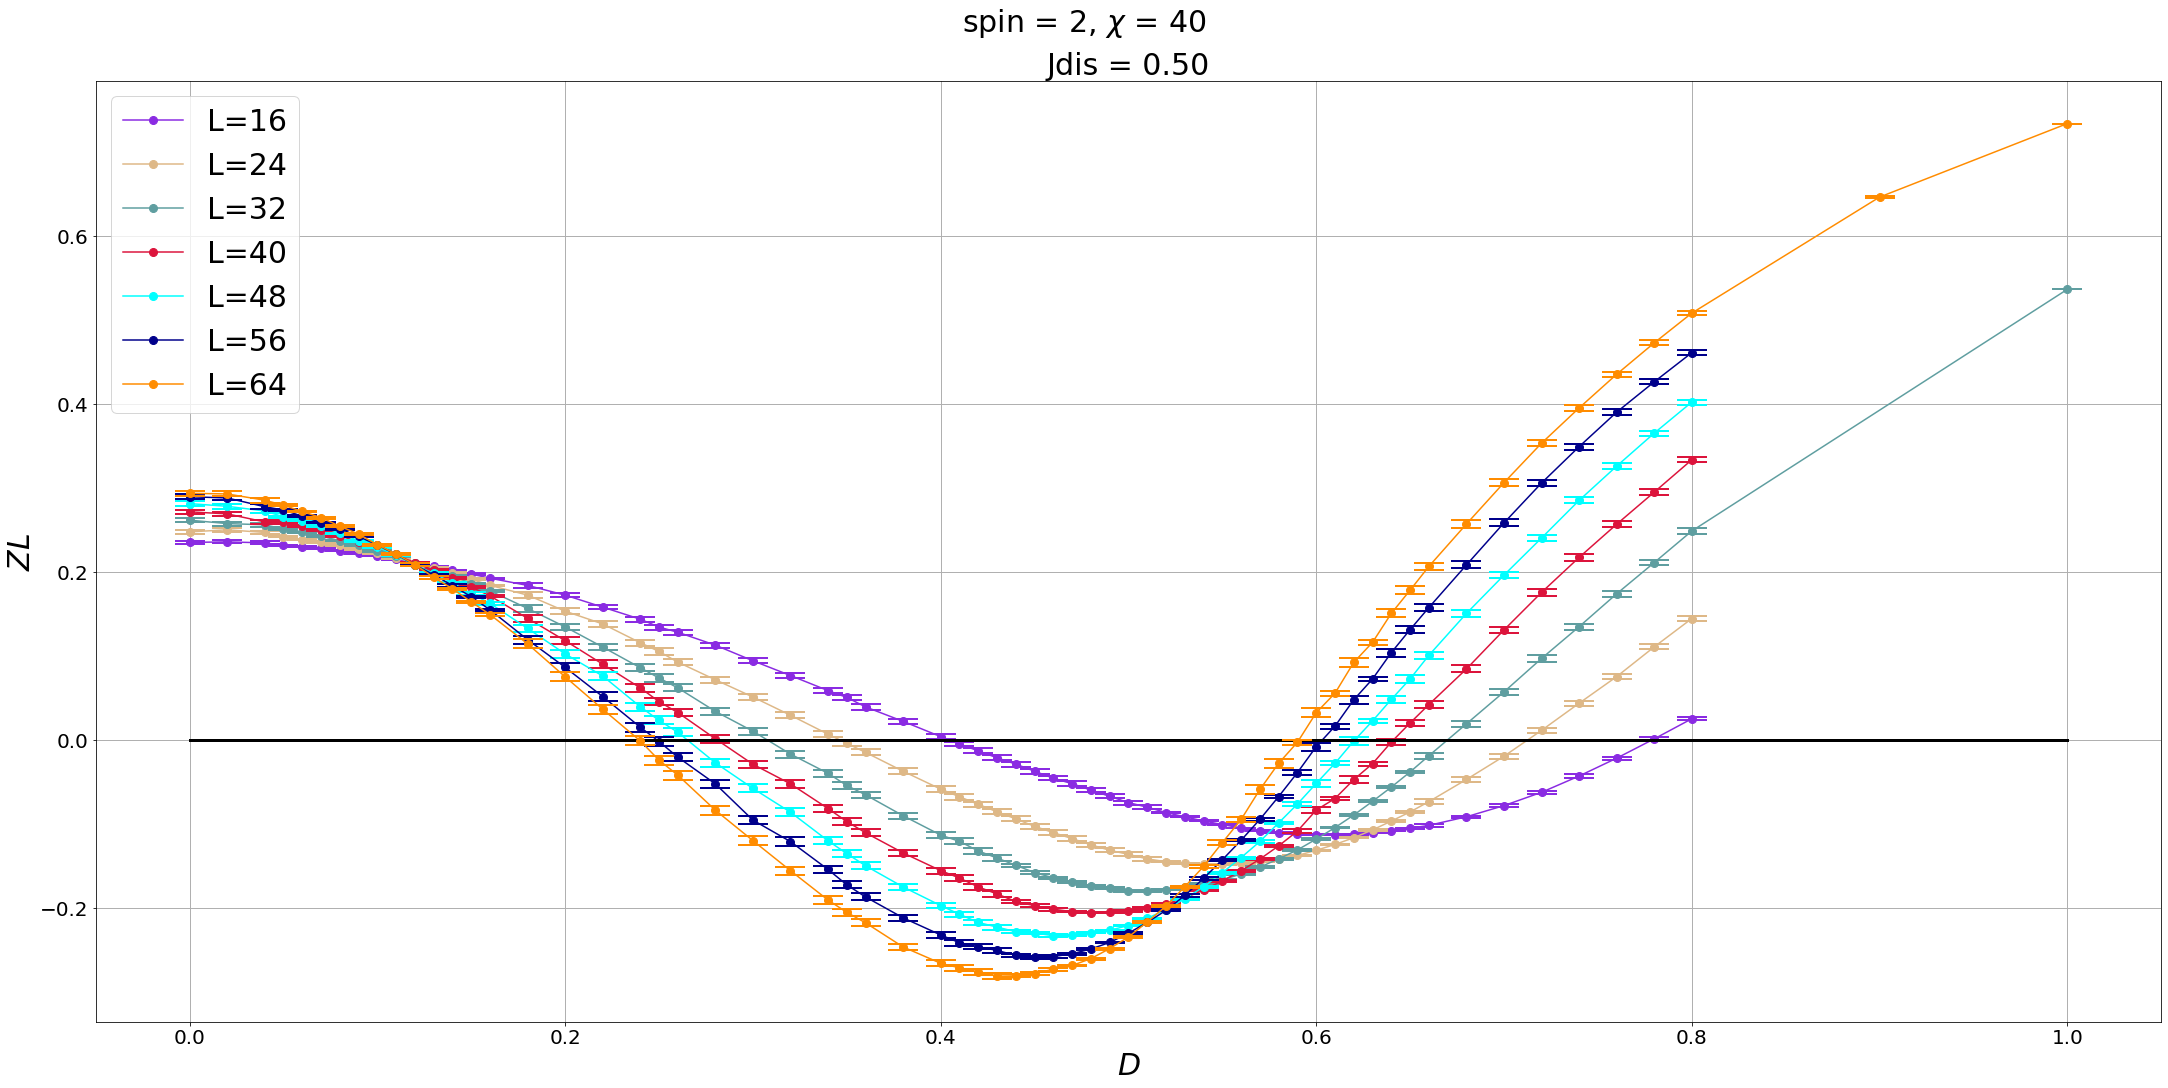

In [57]:
# 固定J, 看L, Order parameter 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64]           ## Choose size 
# Ls = [16,32,48,64]       
Dimer = ALL_Dimer
Jdis = ["Jdis050"]

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        ax.plot(dfplt['Dimer'], dfplt[Para]*0, "-", color='black', linewidth = 3)
        ax.plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 8, label = 'L=%d' %(L))
        ax.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax.set_xlabel(r'$D$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title("Jdis = %.2f" %(J), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0.05, 0.17])
        # ax.set_ylim([0.15, 0.3])
        # ax.set_xlim([0.45, 0.65])
        # ax.set_ylim([-0.3, 0.2])
        ax.legend(loc = 'best',fontsize=30)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.legend(lines, labels, fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

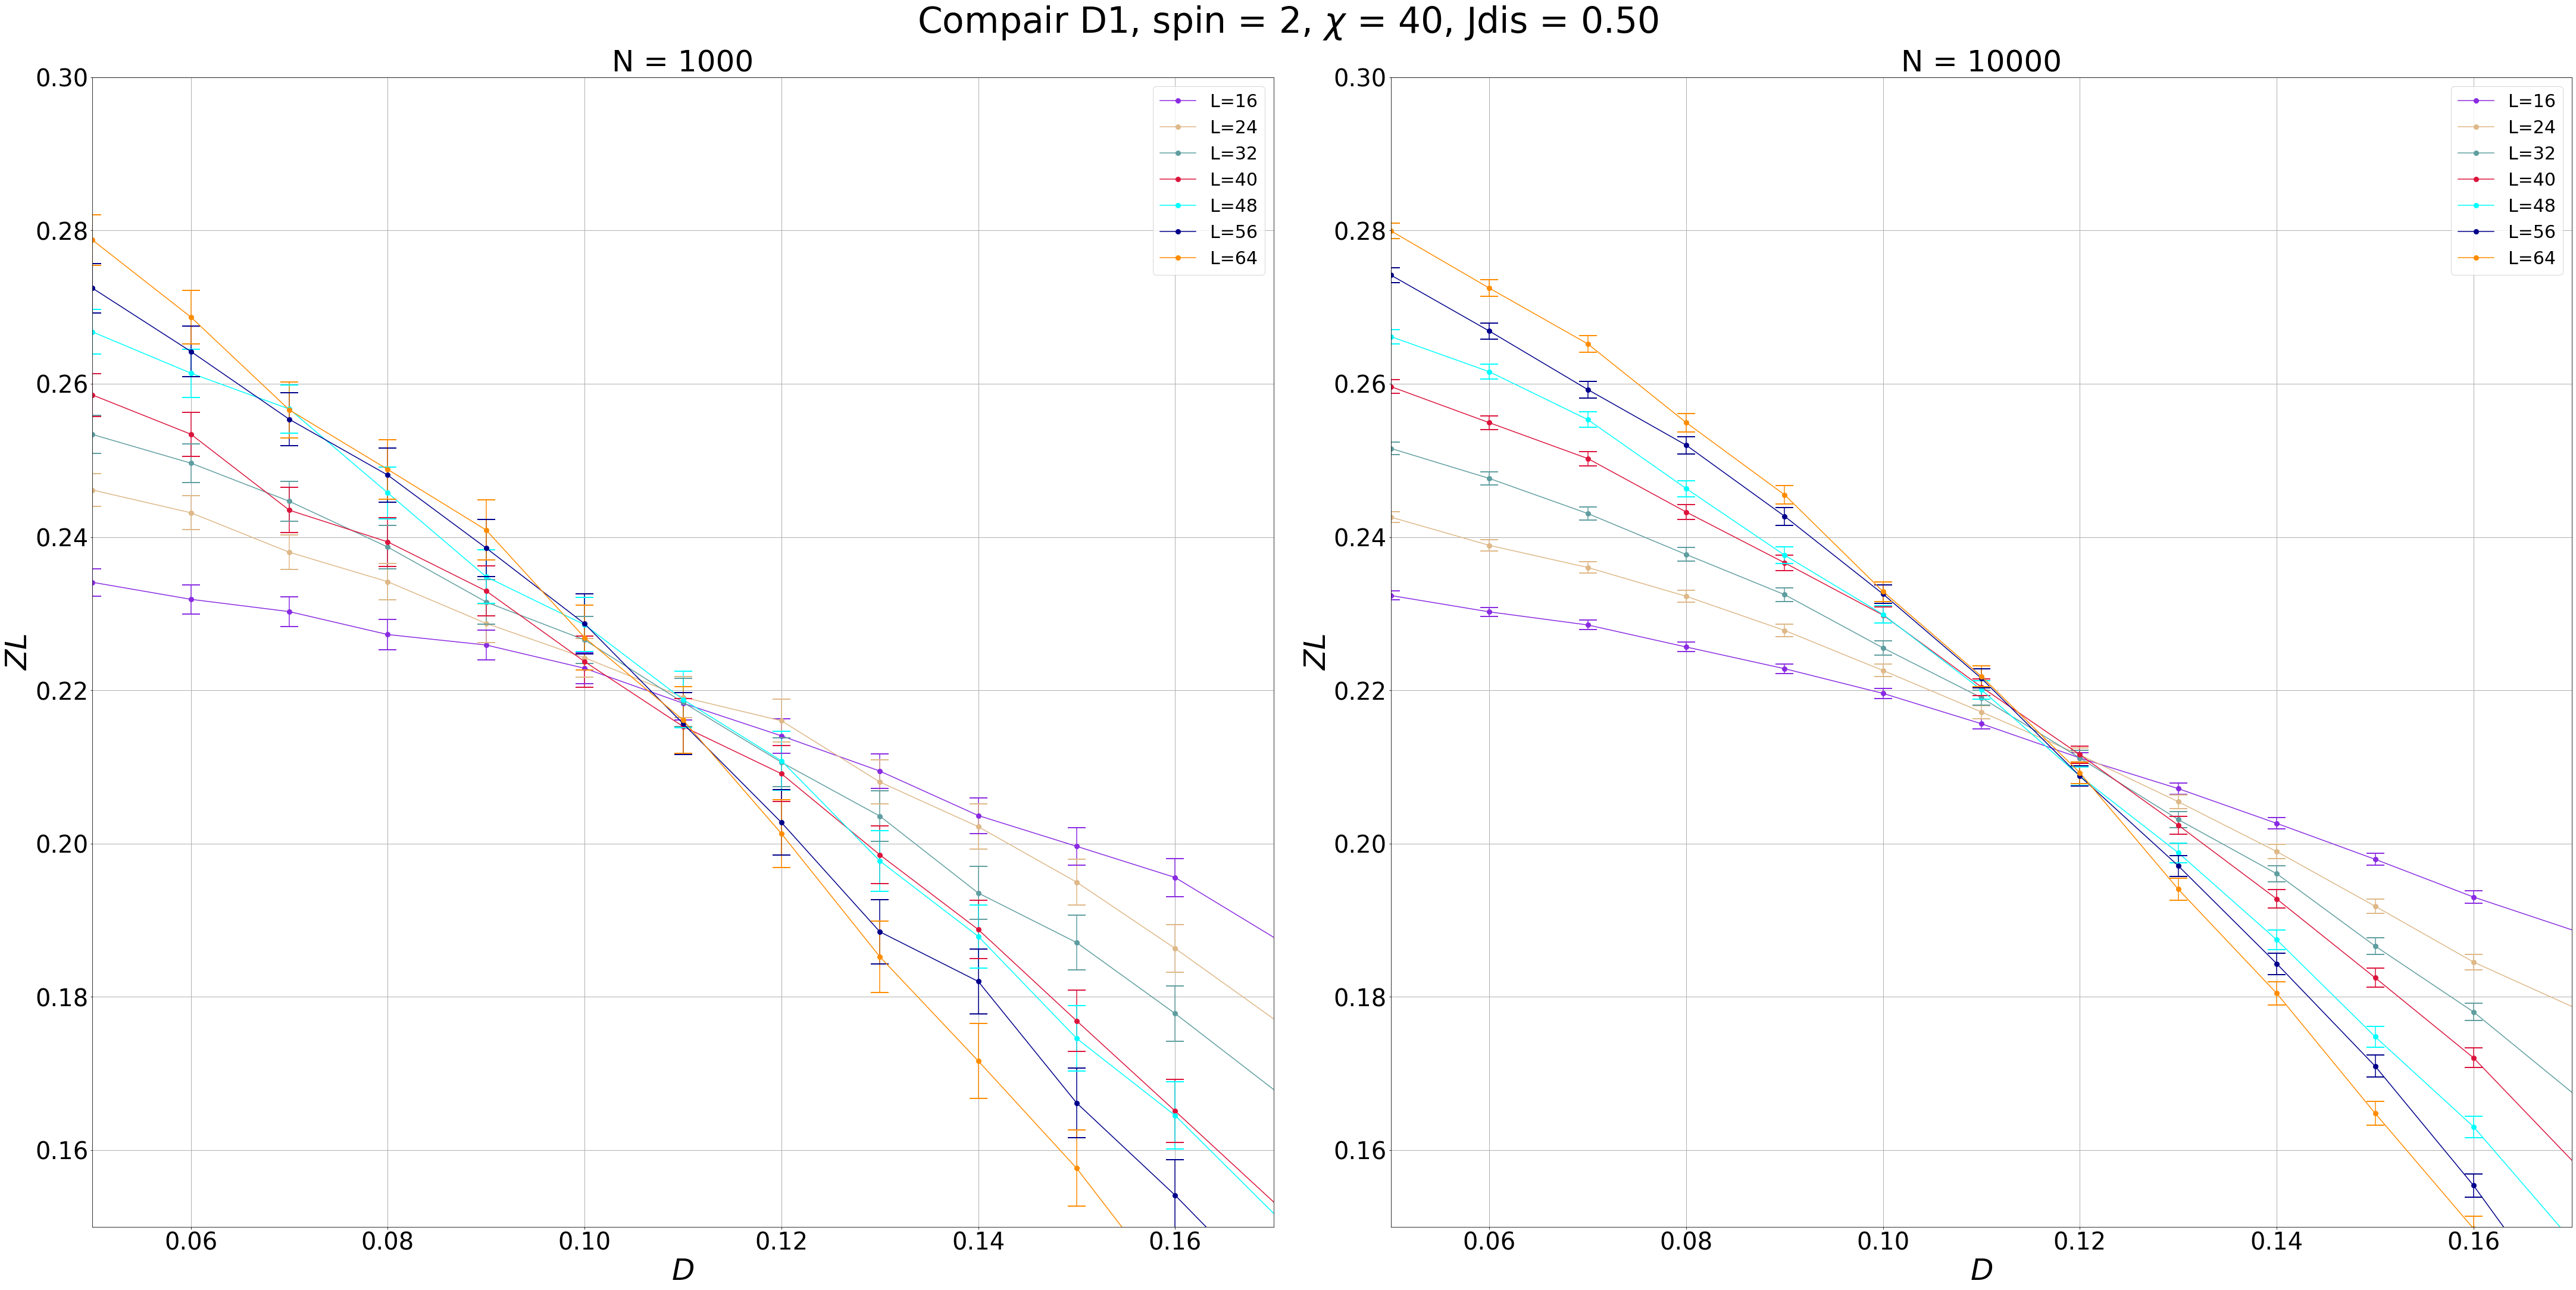

In [52]:
# 固定J, 看L, Order parameter 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64]           ## Choose size 
# Ls = [16,32,48,64]       
Dimer = ALL_Dimer
Jdis = ["Jdis050"]
Ns = [1000, 10000]

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(60,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for n in range(len(Ns)):
        N = Ns[n]

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
            dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

            for d in range(len(Dimer)):
                dimer = Dimer[d]
                D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

                if (N == 10000):
                    myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
                else:
                    myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'_'+ str(N) +'.csv'

                if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                    continue

                df = pd.read_csv(myfile)

                if (OrderPara == "SOP"):
                    mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
                else:
                    mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

                dfplt.loc[d] = mean

            ax[n].plot(dfplt['Dimer'], dfplt[Para]*0, "-", color='black', linewidth = 3)
            ax[n].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 8, label = 'L=%d' %(L))
            ax[n].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
            ax[n].set_xlabel(r'$D$', fontsize=50)
            ax[n].set_ylabel(ylable, fontsize=50)
            ax[n].tick_params(axis='x', labelsize=40) 
            ax[n].tick_params(axis='y', labelsize=40)
            ax[n].set_title("N = %d" %(N), fontsize=50)
            ax[n].grid(linestyle='-', linewidth=1)
            ax[n].set_xlim([0.05, 0.17])
            ax[n].set_ylim([0.15, 0.3])
            # ax[n].set_xlim([0.45, 0.65])
            # ax[n].set_ylim([-0.3, 0.2])
            ax[n].legend(loc = 'best',fontsize=30)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('Compair D1, spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=60)
# fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.legend(lines, labels, fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

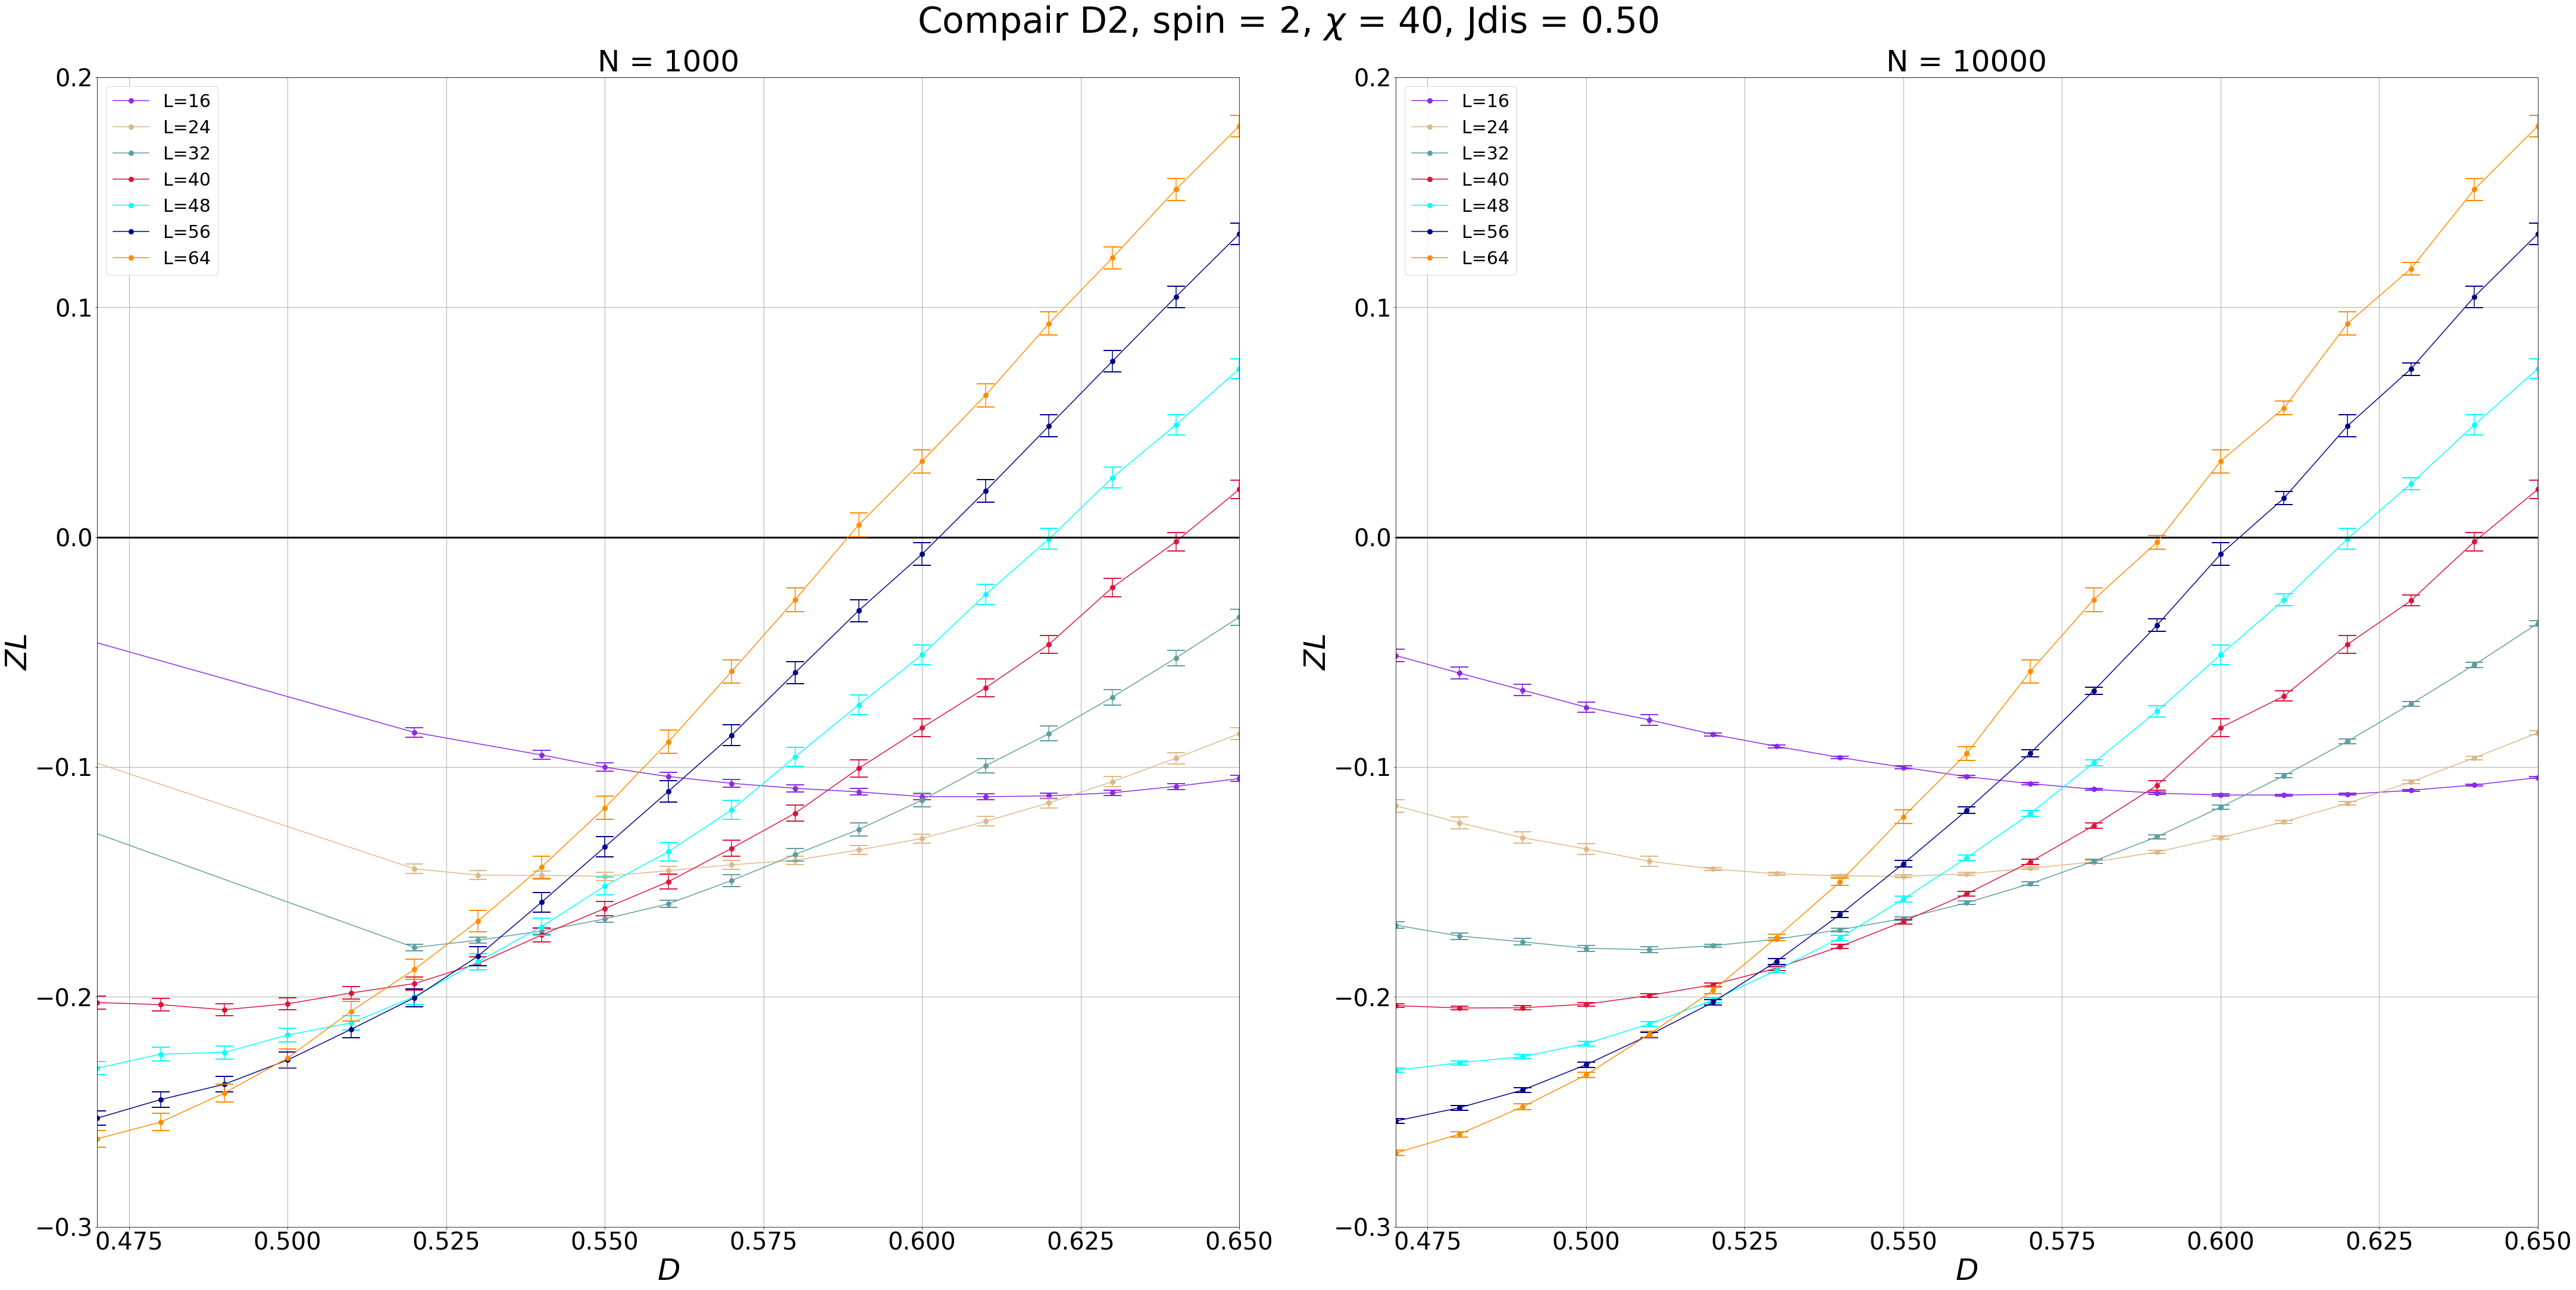

In [53]:
# 固定J, 看L, Order parameter 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64]           ## Choose size 
# Ls = [16,32,48,64]       
Dimer = ALL_Dimer
Jdis = ["Jdis050"]
Ns = [1000, 10000]

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(60,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for n in range(len(Ns)):
        N = Ns[n]

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
            dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

            for d in range(len(Dimer)):
                dimer = Dimer[d]
                D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

                if (N == 10000):
                    myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
                else:
                    myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'_'+ str(N) +'.csv'

                if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                    continue

                df = pd.read_csv(myfile)

                if (OrderPara == "SOP"):
                    mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
                else:
                    mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

                dfplt.loc[d] = mean

            ax[n].plot(dfplt['Dimer'], dfplt[Para]*0, "-", color='black', linewidth = 3)
            ax[n].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 8, label = 'L=%d' %(L))
            ax[n].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
            ax[n].set_xlabel(r'$D$', fontsize=50)
            ax[n].set_ylabel(ylable, fontsize=50)
            ax[n].tick_params(axis='x', labelsize=40) 
            ax[n].tick_params(axis='y', labelsize=40)
            ax[n].set_title("N = %d" %(N), fontsize=50)
            ax[n].grid(linestyle='-', linewidth=1)
            # ax[n].set_xlim([0.05, 0.17])
            # ax[n].set_ylim([0.15, 0.3])
            ax[n].set_xlim([0.47, 0.65])
            ax[n].set_ylim([-0.3, 0.2])
            ax[n].legend(loc = 'best',fontsize=30)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('Compair D2, spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=60)
# fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.legend(lines, labels, fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

## Compair N = 1000、10000, $D_c$(L_diff=0) vs 1/**<font color = red>L</font>**

J = 0.10, L -> oo, D* = 0.1650
J = 0.10, L -> oo, D* = 0.1700
J = 0.50, L -> oo, D* = 0.1216
J = 0.50, L -> oo, D* = 0.1122


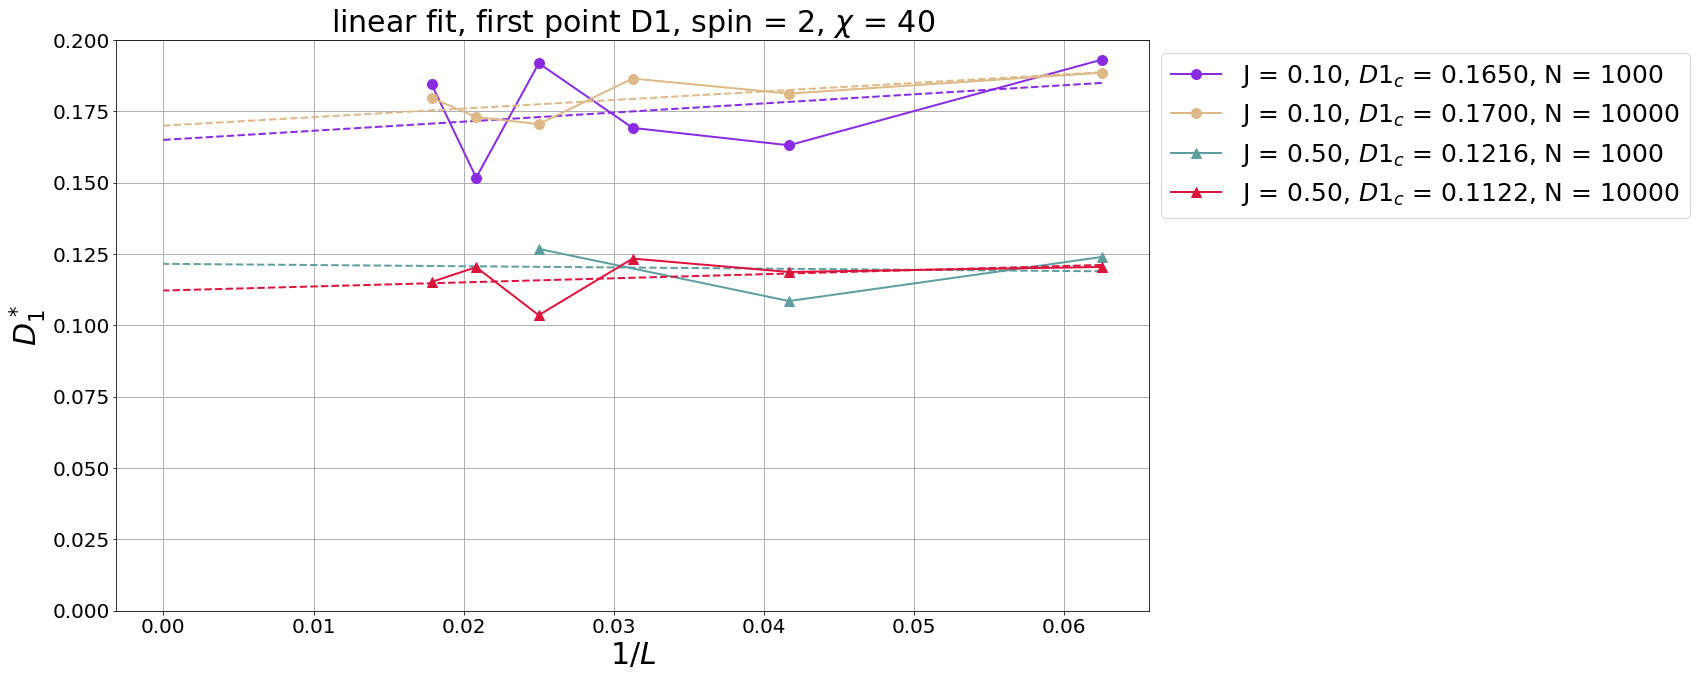

In [33]:
## First crossing point D1
power = 1
OrderPara = "ZL"

if (OrderPara == "ZL"):
    Para = "ZL"

N = [1000 ,10000]
Ls = [16,24,32,40,48,56,64]
# Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]
Jdis = ["Jdis010","Jdis050"]
Dimer = ALL_Dimer[0:30]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

    for n in range(len(N)):
        D1s = []
        x = []

        for l in range(len(Ls)-1):
            skip_L = False
            L1 = Ls[l]
            L2 = Ls[l+1]
            f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
            f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
            f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
            ignore_num = 0
            # print(L1)

            for d in range(len(Dimer)):
                dimer = Dimer[d]
                D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

                if (n == 0):
                    file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'_1000.csv'
                    file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'_1000.csv'
                else:
                    file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
                    file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
                
                if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                    ignore_num += 1
                    continue
            
                df_L1 = pd.read_csv(file_L1)
                df_L2 = pd.read_csv(file_L2)

                mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

                f_L1.loc[d-ignore_num] = mean_L1
                f_L2.loc[d-ignore_num] = mean_L2
                f_diff.loc[d-ignore_num] = mean_diff

            ids, skip_L = find_id(f_diff, skip_L)
            # print(ids)
            if (skip_L):
                continue

            D1 = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
            D1s.append(D1)
            x.append(L1**-1)

        x.append(0)
        p = np.polyfit(x[:-1], D1s, power)
        f = np.polyval(p,x)

        print('J = %.2f, L -> oo, D* = %.4f' %(J, p[power]))
        plt.plot(x[:-1], D1s, marr[j], markersize = font_size/3, color = carr[2*j+n], linewidth = font_size/15, label = 'J = %.2f, $D1_c$ = %.4f, N = %d' %(J, p[power], N[n]))
        plt.plot(x, f, '--', markersize = font_size/3, color = carr[2*j+n], linewidth = font_size/15)

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D_1^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.2)
plt.grid(linestyle='-', linewidth=1)
plt.title('linear fit, first point D1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

J = 0.10, L -> oo, D* = 0.5013
J = 0.10, L -> oo, D* = 0.5012
J = 0.50, L -> oo, D* = 0.4845
J = 0.50, L -> oo, D* = 0.4685


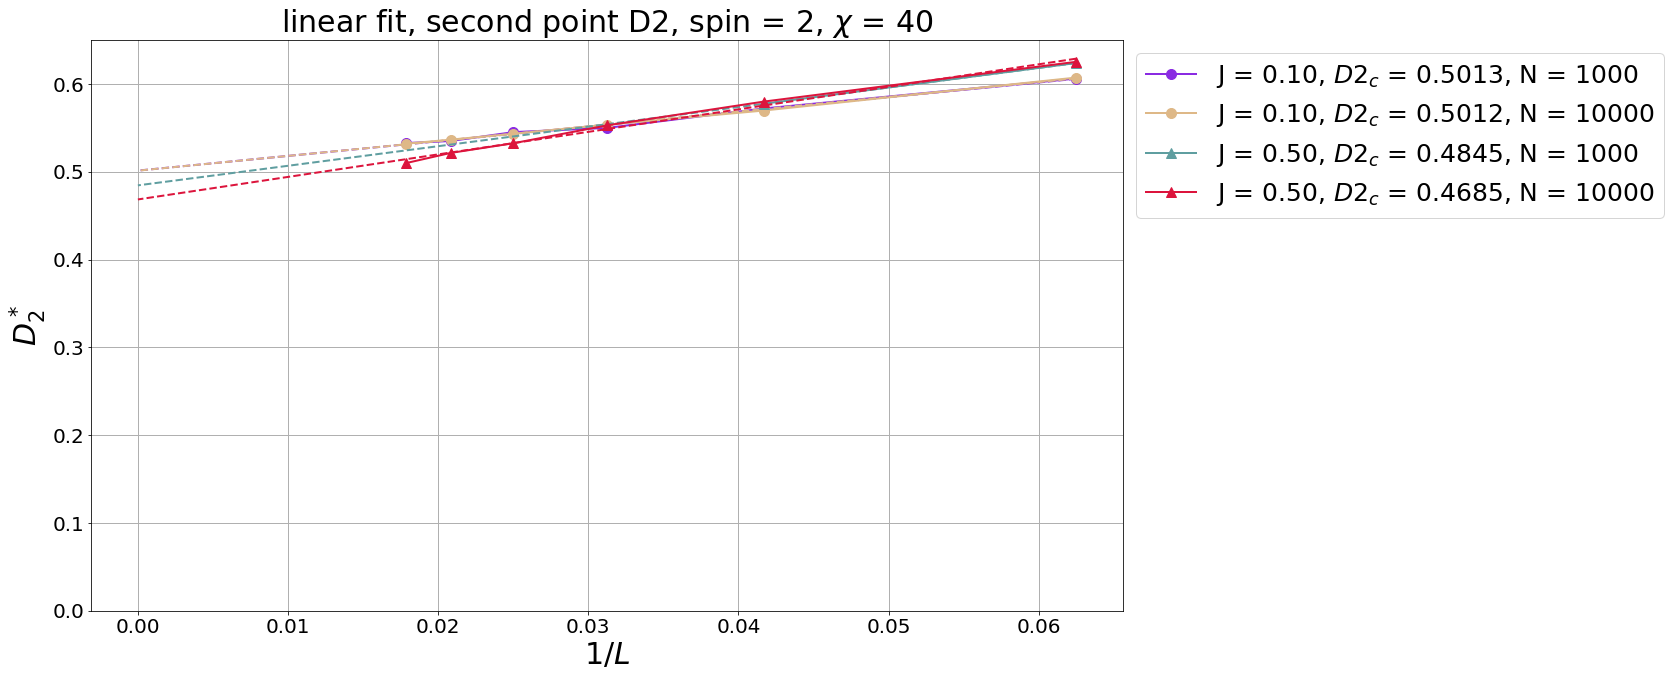

In [30]:
## Secend crossing point D2
power = 1
OrderPara = "ZL"

if (OrderPara == "ZL"):
    Para = "ZL"

N = [1000, 10000]
Ls = [16,24,32,40,48,56,64]
# Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100","Jdis150","Jdis200","Jdis250"]
Jdis = ["Jdis010","Jdis050"]
Dimer = ALL_Dimer[47:66]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

    for n in range(len(N)):
        D2s = []
        x = []
        
        if (J > 0.8):
            Ls = [16,32,48,64]
            Dimer = ALL_Dimer[10:70]

        for l in range(len(Ls)-1):
            skip_L = False
            L1 = Ls[l]
            L2 = Ls[l+1]
            f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
            f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
            f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
            ignore_num = 0
            # print(L1)

            for d in range(len(Dimer)):
                dimer = Dimer[d]
                D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
            
                if (n == 0):
                    file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'_1000.csv'
                    file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'_1000.csv'
                else:
                    file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
                    file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
                
                if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                    ignore_num += 1
                    continue
            
                df_L1 = pd.read_csv(file_L1)
                df_L2 = pd.read_csv(file_L2)

                if (OrderPara == "SOP"):
                    mean_L1 = {'Dimer':D, 'ZL':-df_L1[Para][0]}
                    mean_L2 = {'Dimer':D, 'ZL':-df_L2[Para][0]}
                    mean_diff = {'Dimer':D, 'diff':df_L1[Para][0]-df_L2[Para][0]}
                else:
                    mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
                    mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
                    mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

                f_L1.loc[d-ignore_num] = mean_L1
                f_L2.loc[d-ignore_num] = mean_L2
                f_diff.loc[d-ignore_num] = mean_diff

            ids, skip_L = find_id(f_diff, skip_L)
            # print(ids)
            if (skip_L):
                continue
            D2 = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
            D2s.append(D2)
            x.append(L1**-1)

        x.append(0)
        p = np.polyfit(x[:-1], D2s, power)
        f = np.polyval(p,x)

        print('J = %.2f, L -> oo, D* = %.4f' %(J, p[power]))
        plt.plot(x[:-1], D2s, marr[j], markersize = font_size/3, color = carr[2*j+n], linewidth = font_size/15, label = 'J = %.2f, $D2_c$ = %.4f, N = %d' %(J, p[power], N[n]))
        plt.plot(x, f, '--', markersize = font_size/3, color = carr[2*j+n], linewidth = font_size/15)

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D_2^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.65)
plt.grid(linestyle='-', linewidth=1)
plt.title('linear fit, second point D2, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## 線性 fitting $D_c$(L_diff=0) vs 1/**<font color = red>L</font>**

In [5]:
PhaseDiagram_D1 = pd.DataFrame(columns = ['J', 'D1'])
PhaseDiagram_D2 = pd.DataFrame(columns = ['J', 'D2'])

J = 0.10, L -> oo, D* = 0.1700
J = 0.20, L -> oo, D* = 0.1481
J = 0.30, L -> oo, D* = 0.1145
J = 0.40, L -> oo, D* = 0.1243
J = 0.50, L -> oo, D* = 0.1122
J = 0.60, L -> oo, D* = 0.0578
J = 0.70, L -> oo, D* = 0.0604


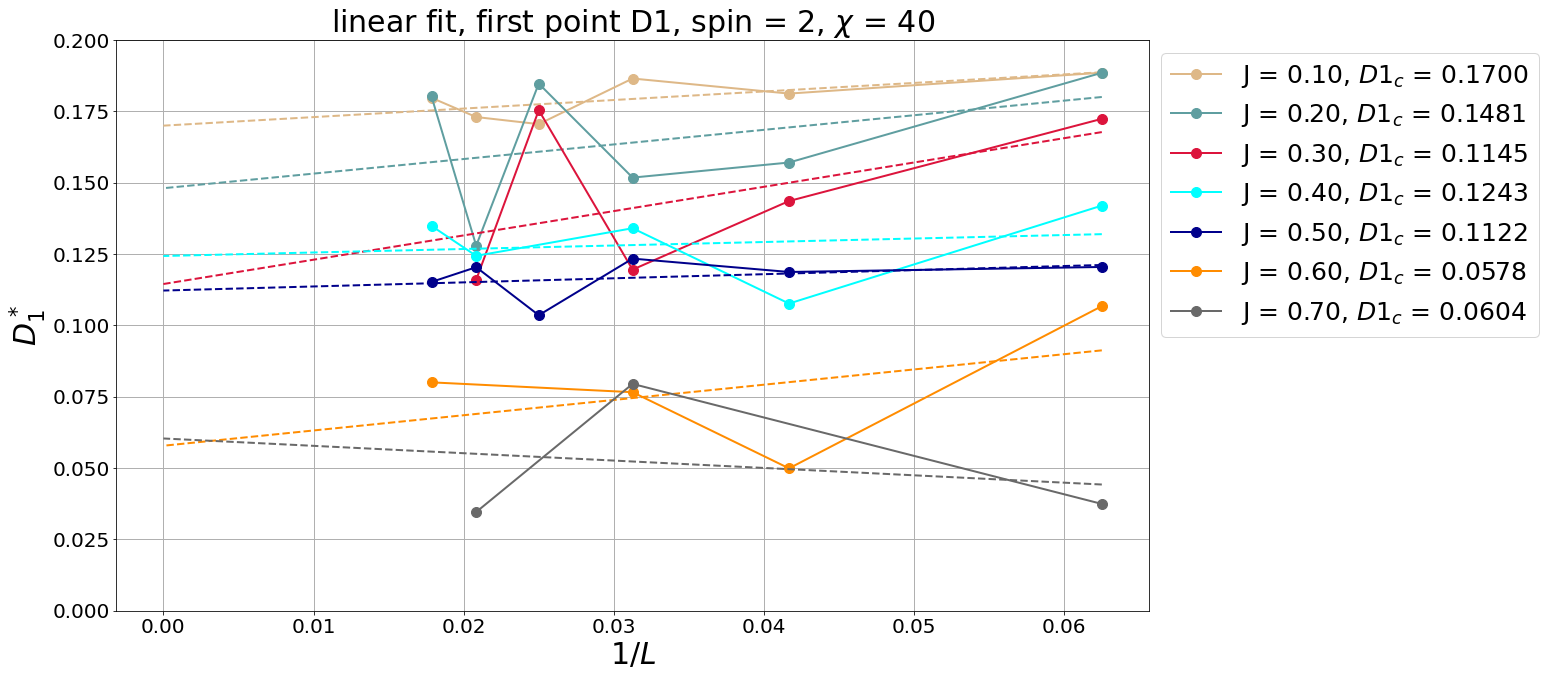

In [25]:
## First crossing point D1
power = 1
OrderPara = "ZL"

if (OrderPara == "ZL"):
    Para = "ZL"

Ls = [16,24,32,40,48,56,64]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]
Dimer = ALL_Dimer[0:30]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    D1s = []
    x = []    

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0
        # print(L1)

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
            mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)
        # print(ids)
        if (skip_L):
            continue

        D1 = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
        D1s.append(D1)
        x.append(L1**-1)

    x.append(0)
    p = np.polyfit(x[:-1], D1s, power)
    f = np.polyval(p,x)

    print('J = %.2f, L -> oo, D* = %.4f' %(J, p[power]))
    plt.plot(x[:-1], D1s, 'o-', markersize = font_size/3, color = carr[j+n], linewidth = font_size/15, label = 'J = %.2f, $D1_c$ = %.4f' %(J, p[power]))
    plt.plot(x, f, '--', markersize = font_size/3, color = carr[j+n], linewidth = font_size/15)

    mean_D = {'J':J, 'D1':p[power]}
    PhaseDiagram_D1.loc[j] = mean_D

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D_1^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.2)
plt.grid(linestyle='-', linewidth=1)
plt.title('linear fit, first point D1, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

J = 0.10, L -> oo, D* = 0.5012
J = 0.20, L -> oo, D* = 0.4963
J = 0.30, L -> oo, D* = 0.4891
J = 0.40, L -> oo, D* = 0.4782
J = 0.50, L -> oo, D* = 0.4685
J = 0.60, L -> oo, D* = 0.4434
J = 0.70, L -> oo, D* = 0.4170
J = 0.80, L -> oo, D* = 0.4119
J = 0.90, L -> oo, D* = 0.3987
J = 1.00, L -> oo, D* = 0.3767
J = 1.50, L -> oo, D* = 0.2757
J = 2.00, L -> oo, D* = 0.2526
J = 2.50, L -> oo, D* = 0.2308


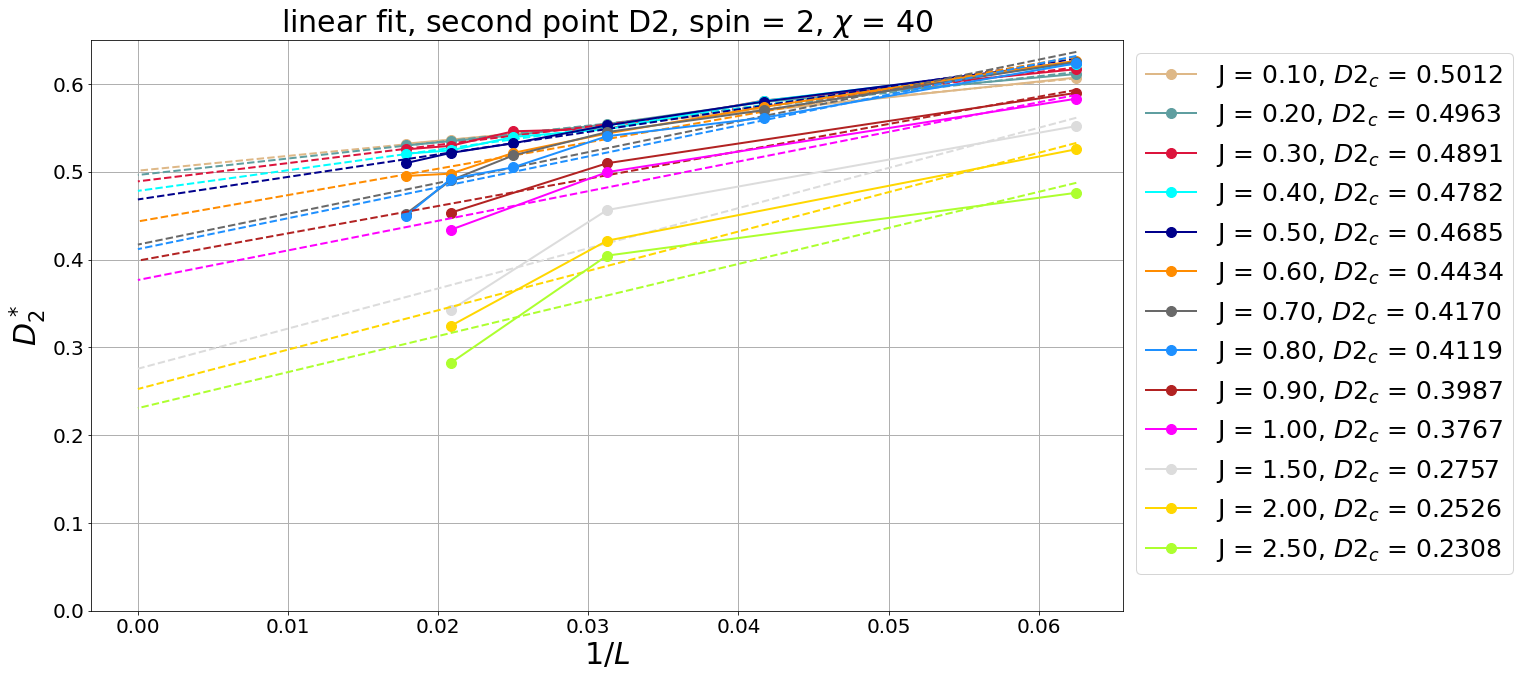

In [22]:
## Secend crossing point D2
power = 1
OrderPara = "ZL"

if (OrderPara == "ZL"):
    Para = "ZL"

Ls = [16,24,32,40,48,56,64]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100","Jdis150","Jdis200","Jdis250"]
# Jdis = ["Jdis060"]
Dimer = ALL_Dimer[40:66]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    D2s = []
    x = []    

    if (J > 0.8):
        Ls = [16,32,48,64]
        Dimer = ALL_Dimer[10:70]

    for l in range(len(Ls)-1):
        skip_L = False
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0
        # print(L1)

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            file_L1 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            file_L2 = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                ignore_num += 1
                continue
        
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
            mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
            mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        ids, skip_L = find_id(f_diff, skip_L)
        # print(ids)
        if (skip_L):
            continue
        D2 = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
        D2s.append(D2)
        x.append(L1**-1)

    x.append(0)
    p = np.polyfit(x[:-1], D2s, power)
    f = np.polyval(p,x)

    print('J = %.2f, L -> oo, D* = %.4f' %(J, p[power]))
    plt.plot(x[:-1], D2s, 'o-', markersize = font_size/3, color = carr[j+n], linewidth = font_size/15, label = 'J = %.2f, $D2_c$ = %.4f' %(J, p[power]))
    plt.plot(x, f, '--', markersize = font_size/3, color = carr[j+n], linewidth = font_size/15)

    mean_D = {'J':J, 'D2':p[power]}
    PhaseDiagram_D2.loc[j] = mean_D

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D_2^*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
# plt.xlim(0, 0.07)
plt.ylim(0, 0.65)
plt.grid(linestyle='-', linewidth=1)
plt.title('linear fit, second point D2, spin = %s, $\chi$ = %d' % (spin, M), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.show()

## Fix **<font color = yellow>J</font>**, look **<font color = green>D</font>**, **Order Parameter** vs 1/**<font color = red>L</font>**

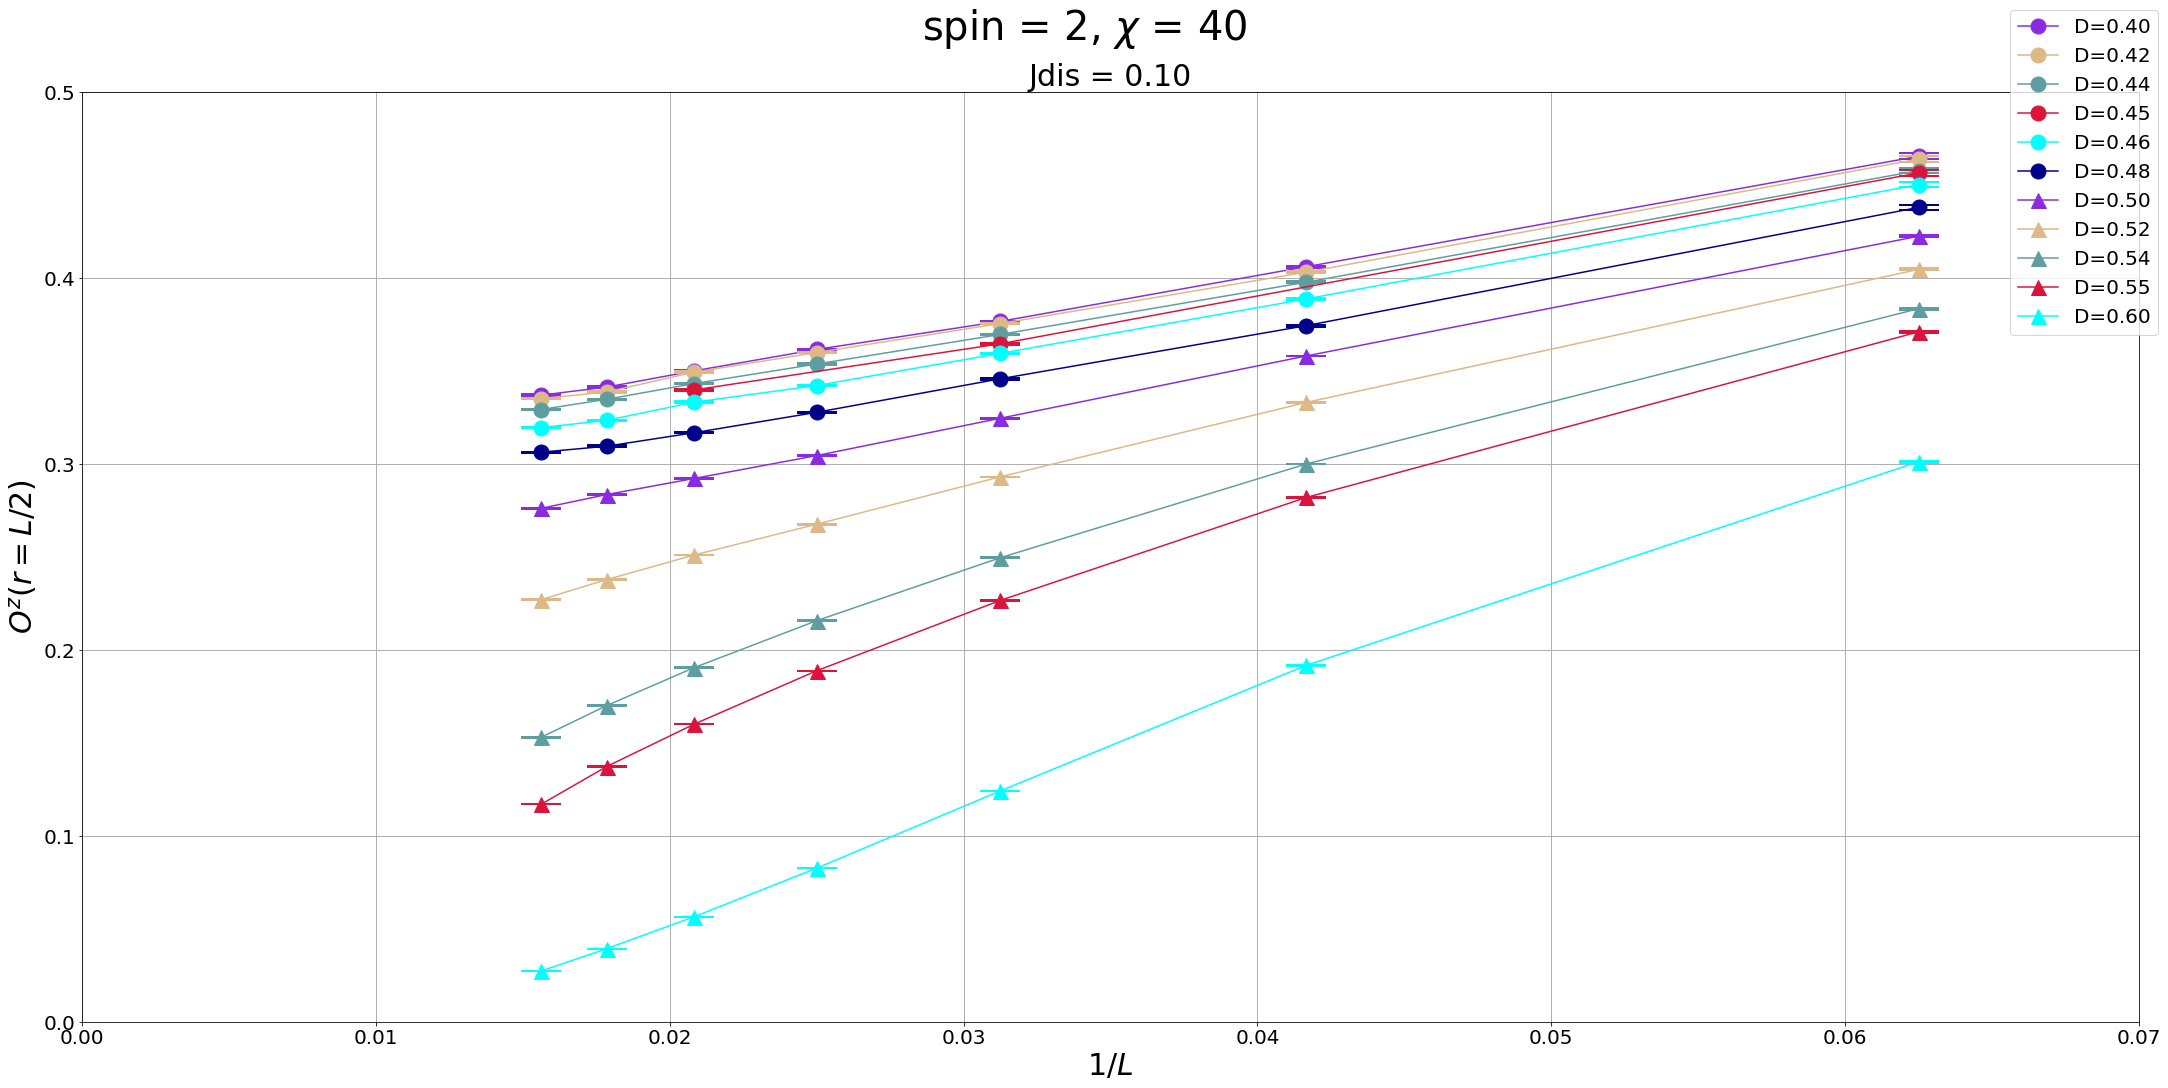

In [6]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
Dimer = ["Dim040","Dim042","Dim044","Dim045","Dim046","Dim048","Dim050","Dim052","Dim054","Dim055","Dim060"]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim030","Dim040","Dim050","Dim055","Dim060","Dim065"]
Jdis = ["Jdis010"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        ax.plot(dfplt['1/L'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f' %(D))
        ax.errorbar(dfplt['1/L'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax.set_xlabel(r'$1/L$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title("Jdis = %.2f" %(J), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        ax.set_xlim([0,0.07])
        ax.set_ylim([0, 0.5])
        # ax.legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

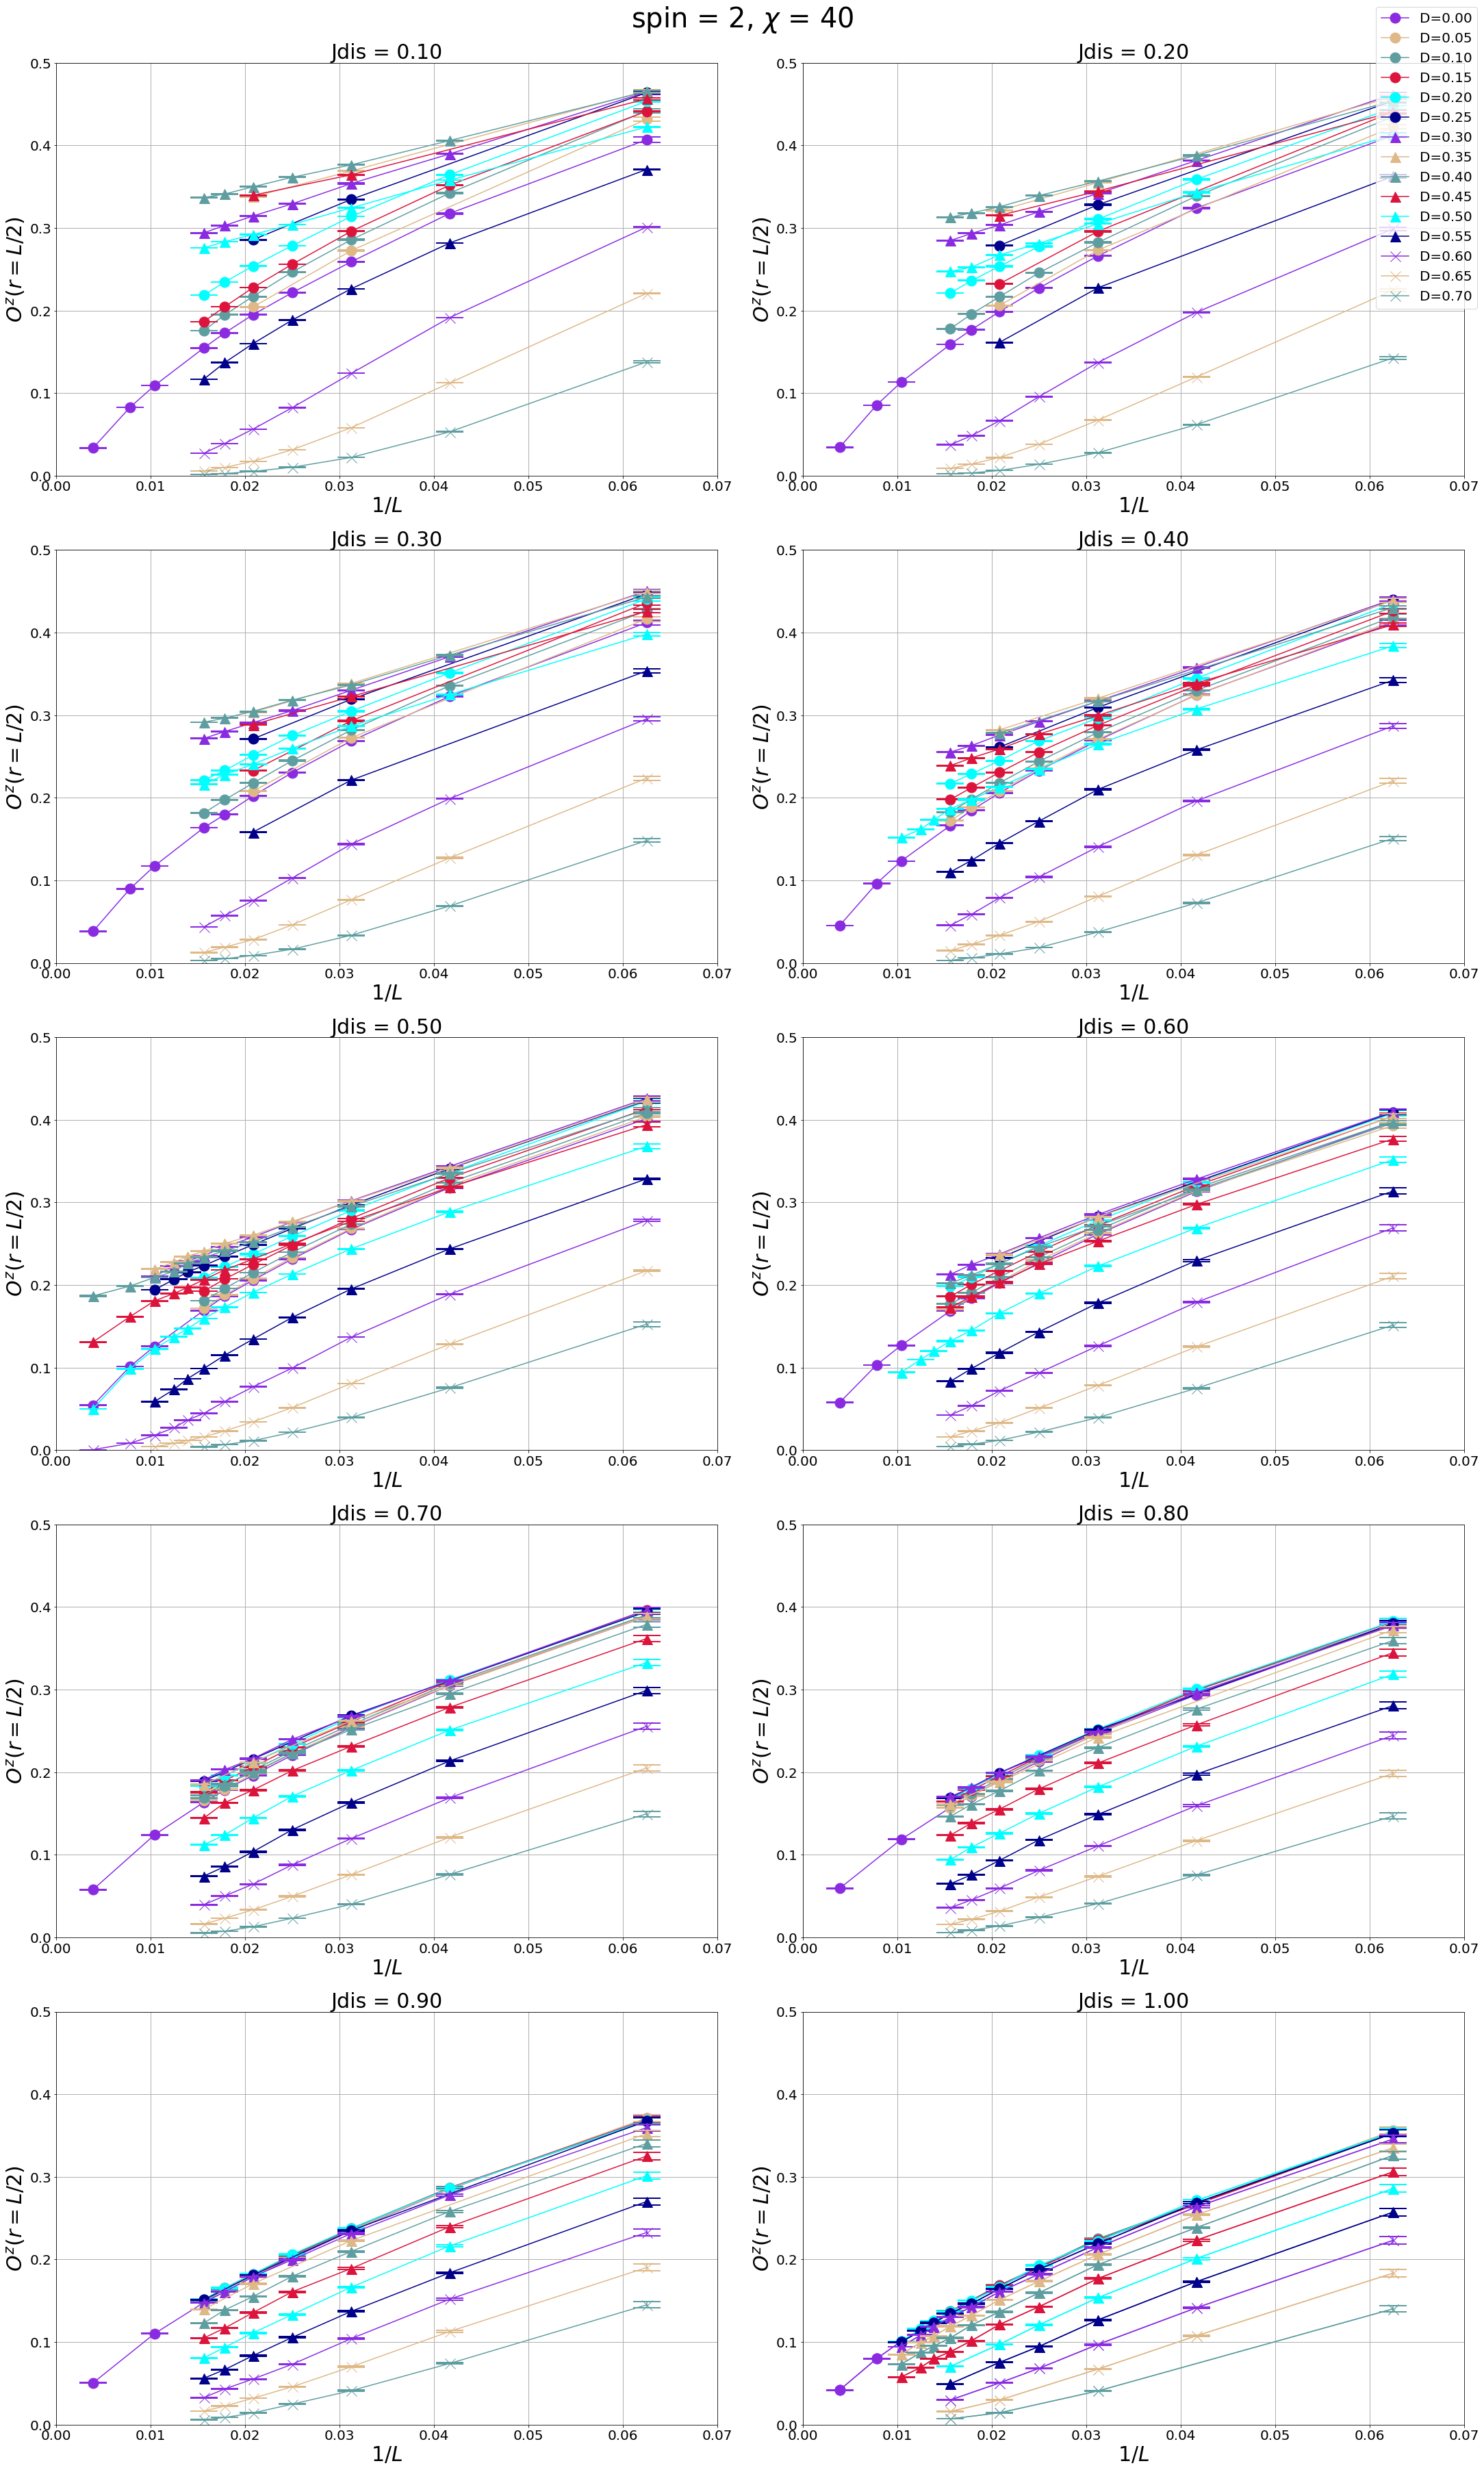

In [55]:
## Multiplot
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,50))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        if (j == len(Jdis)-1):
            ax[int(j/2)][j-2*int(j/2)].plot(dfplt['1/L'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f' %(D))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['1/L'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['1/L'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$1/L$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0,0.07])
        ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.5])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

## Fix **<font color = yellow>J</font>**, look **<font color = green>D</font>**, **Order Parameter** v.s. **<font color = red>L</font>**$^{-\eta_{st}}$

0.1994275796834751
0.17578033178923233
0.18550551455199082
0.1692130657502267


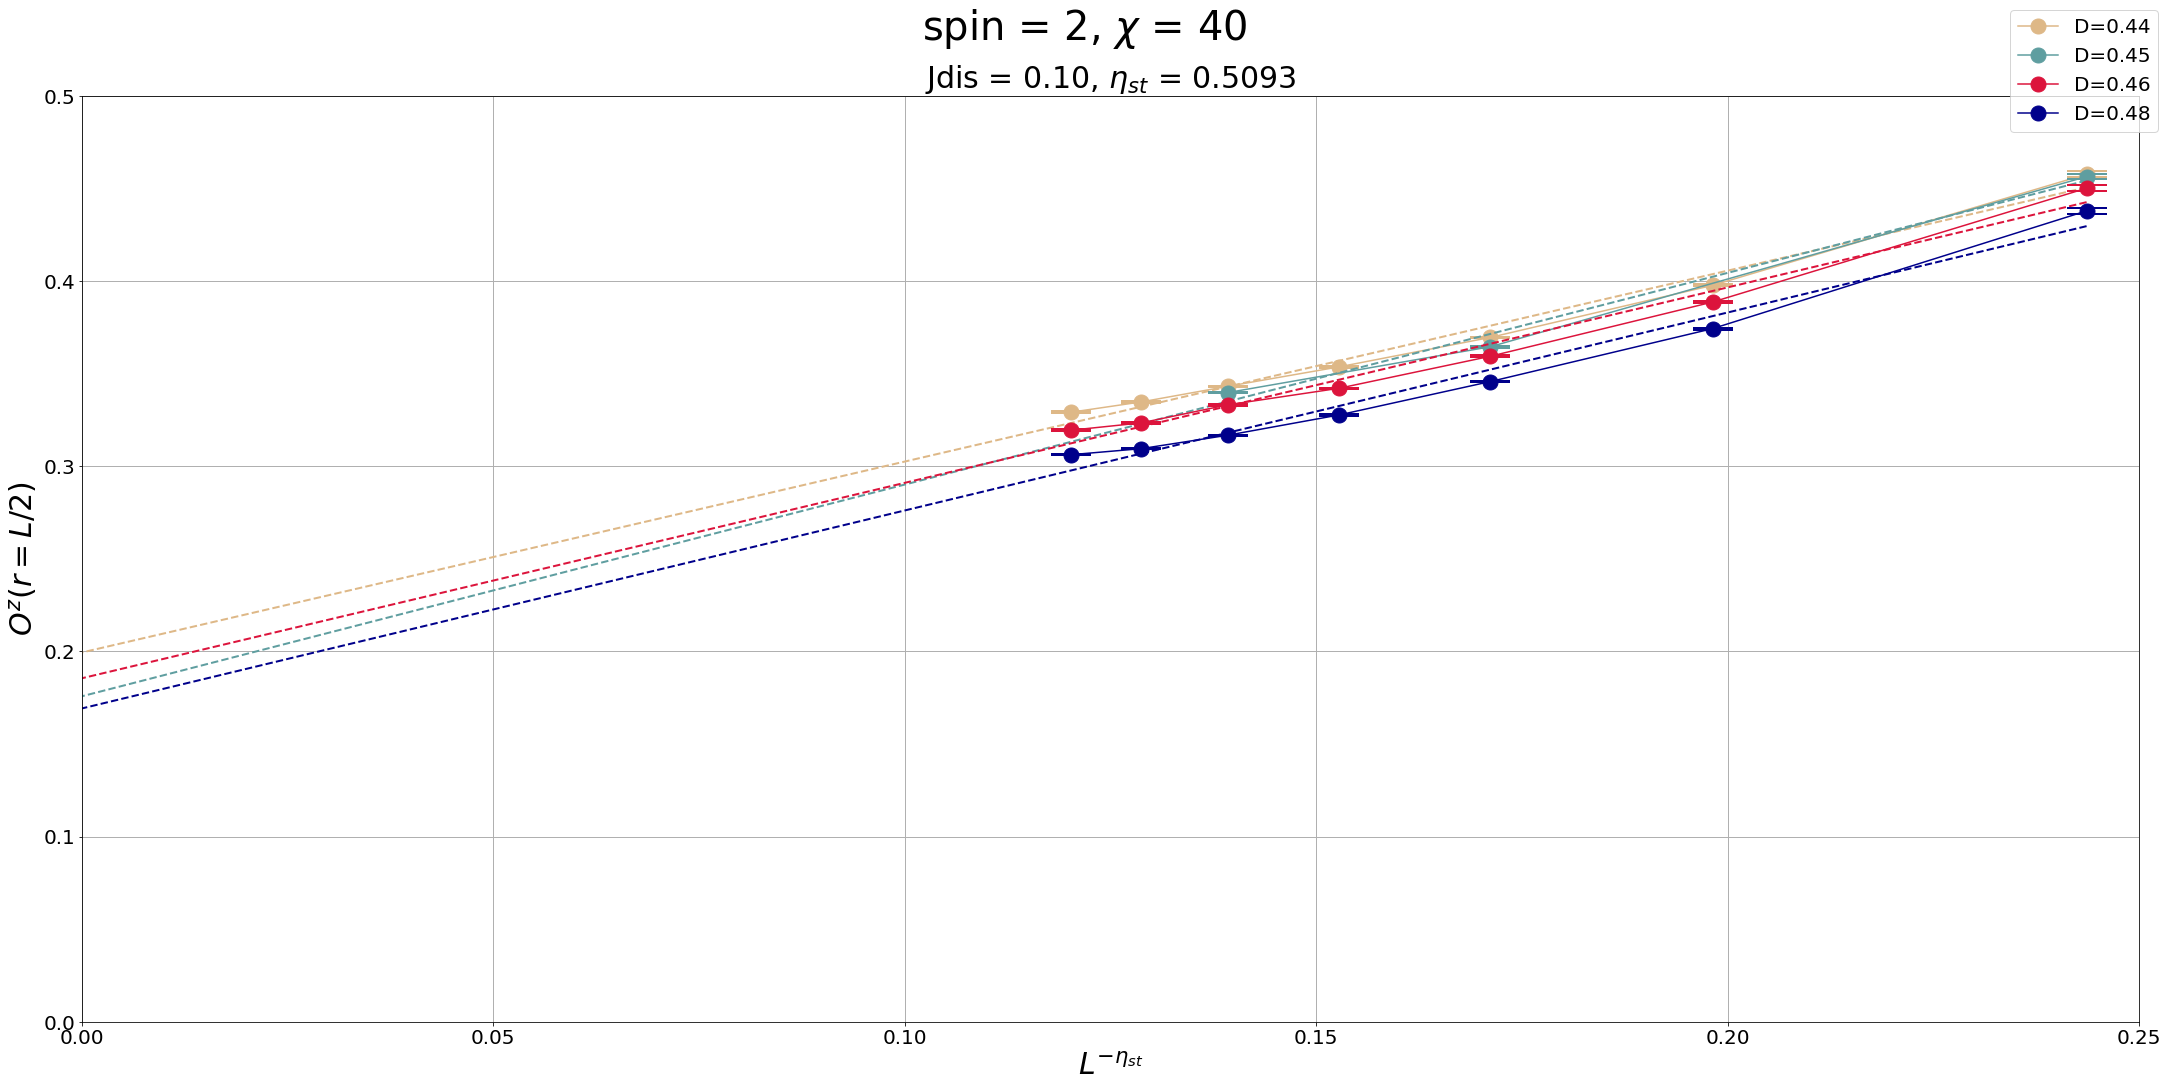

In [52]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80]
Dimer = ["Dim043","Dim044","Dim045","Dim046","Dim047","Dim048"]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim030","Dim040","Dim050","Dim055","Dim060","Dim065"]
Jdis = ["Jdis010"]
eta = 0.5093

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['L**-eta', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'L**-eta':L**-eta, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'L**-eta':L**-eta, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        if (dfplt.empty):
            continue

        a, b  = np.polyfit(dfplt['L**-eta'], dfplt[Para], 1)
        print(b)
        fit_x = dfplt['L**-eta'].copy()
        fit_x.loc[fit_x.index.max()+1] = 0
        fit_y = [i * a + b for i in fit_x]
        ax.plot(fit_x, fit_y, "--", markersize = font_size/3, color=carr[d%6], linewidth = font_size/15)

        ax.plot(dfplt['L**-eta'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f' %(D))
        ax.errorbar(dfplt['L**-eta'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax.set_xlabel(r'$L^{-\eta_{st}}$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title(r"Jdis = %.2f, $\eta_{st}$ = %.4f" %(J, eta), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        ax.set_xlim([0,0.25])
        ax.set_ylim([0, 0.5])
        # ax.legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
OrderPara = "SOP"  ## Choose SOP or ZL
eta = 0.5093
Para = "O^z"
ylable = r'$O^z(r=L/2)$'

Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
Dimer = ["Dim000","Dim010","Dim020","Dim030","Dim040","Dim043","Dim044","Dim045","Dim046","Dim047","Dim048","Dim049","Dim050","Dim060","Dim070"]
Jdis = ["Jdis050"]
INF_Oz_D = []

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['L**-eta', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)
            mean = {'L**-eta':L**-eta, Para:-1*df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        if (dfplt.empty):
            continue

        a, b  = np.polyfit(dfplt['L**-eta'], dfplt[Para], 1)
        INF_Oz_D.append(b)
        
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))
for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    dfplt_inf = pd.DataFrame(columns = ['D', Para, 'error'])

    for l in range(len(Ls)):
        L = Ls[l]
        dfplt = pd.DataFrame(columns = ['D', Para, 'error']) 
         
        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
            
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'D':D, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'D':D, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[d] = mean

        if (dfplt.empty):
            print('L_'+ str(L) +' is empty')
            continue
        
        if (l == 0):
            dfplt_inf['D'] = dfplt['D'].copy()

        ax.plot(dfplt['D'], dfplt[Para], marr[int(l/6)], color=carr[l%6], markersize = 15, label = 'L = %d' %(L))
        # ax.errorbar(dfplt['D'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax.set_xlabel(r'$D$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title(r"Jdis = %.2f, $\eta_{st}$ = %.4f" %(J, eta), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0,0.25])
        ax.set_ylim([0, 0.5])
        # ax.legend(loc = 'best',fontsize=font_size*5/6)

    ax.plot(dfplt_inf['D'], INF_Oz_D, 'o-', color = 'black', markersize = 15, label = r'L = $\infty$')
    
# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
## Multiplot
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
# Jdis = ["Jdis000"]
eta = 0.5093

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,40))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['L**-eta', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'L**-eta':L**-eta, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'L**-eta':L**-eta, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        a, b  = np.polyfit(dfplt['L**-eta'], dfplt[Para], 1)
        fit_x = dfplt['L**-eta'].copy()
        fit_x.loc[fit_x.index.max()+1] = 0
        fit_y = [i * a + b for i in fit_x]

        if (j == len(Jdis)-1):
            ax[int(j/2)][j-2*int(j/2)].plot(dfplt['L**-eta'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f' %(D))
            ax[int(j/2)][j-2*int(j/2)].plot(fit_x, fit_y, "--", color=carr[d%6], linewidth = font_size/15) ## fitting line

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['L**-eta'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15)
        ax[int(j/2)][j-2*int(j/2)].plot(fit_x, fit_y, "--", color=carr[d%6], linewidth = font_size/15) ## fitting line
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['L**-eta'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$L^{-\eta_{st}}$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0,0.25])
        ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.5])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d, $\eta_{st}$ = %.4f' % (spin, M, eta), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
## OBC - Multiplot

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
Dimer = ["Dim000"]
Jdis = ["Jdis000","Jdis020","Jdis040","Jdis060","Jdis080","Jdis100"]
eta = 0.5093

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(3, 2, constrained_layout=True, figsize=(30,25))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['L**-eta', Para, 'error'])
        dfplt_pbc = pd.DataFrame(columns = ['L**-eta', Para, 'error'])    

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/OBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            myfile_pbc = my_metadata_file + OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L) +'_P'+ str(P) +'_m'+ str(M) +'_'+ OrderPara +'.csv'
            if (os.path.exists(myfile) == False or os.path.exists(myfile_pbc) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)
            df_pbc = pd.read_csv(myfile_pbc)

            if (OrderPara == "SOP"):
                mean = {'L**-eta':L**-eta, Para:-1*df[Para][0], 'error':df["error"][0]}
                mean_pbc = {'L**-eta':L**-eta, Para:-1*df_pbc[Para][0], 'error':df_pbc["error"][0]}
            else:
                mean = {'L**-eta':L**-eta, Para:df[Para][0], 'error':df["error"][0]}
                mean_pbc = {'L**-eta':L**-eta, Para:df_pbc[Para][0], 'error':df_pbc["error"][0]}

            dfplt.loc[l] = mean
            dfplt_pbc.loc[l] = mean_pbc

        a, b  = np.polyfit(dfplt['L**-eta'], dfplt[Para], 1)
        a2, b2  = np.polyfit(dfplt['L**-eta'], dfplt_pbc[Para], 1)
        fit_x = dfplt['L**-eta'].copy()
        fit_x2 = dfplt_pbc['L**-eta'].copy()
        fit_x.loc[fit_x.index.max()+1] = 0
        fit_x2.loc[fit_x2.index.max()+1] = 0
        fit_y = [i * a + b for i in fit_x]
        fit_y2 = [i * a2 + b2 for i in fit_x2]

        if (j == len(Jdis)-1):
            ax[int(j/2)][j-2*int(j/2)].plot(dfplt['L**-eta'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15, label = 'D=%.2f, OBC' %(D))
            ax[int(j/2)][j-2*int(j/2)].plot(fit_x, fit_y, "--", color=carr[d%6], linewidth = font_size/15) ## fitting line
            ax[int(j/2)][j-2*int(j/2)].plot(dfplt_pbc['L**-eta'], dfplt_pbc[Para], marr[int(d/6)], color=carr[d%6+6], markersize = 15, label = 'D=%.2f, PBC' %(D))
            ax[int(j/2)][j-2*int(j/2)].plot(fit_x2, fit_y2, "--", color=carr[d%6+6], linewidth = font_size/15) ## fitting line

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['L**-eta'], dfplt[Para], marr[int(d/6)], color=carr[d%6], markersize = 15)
        ax[int(j/2)][j-2*int(j/2)].plot(fit_x, fit_y, "--", color=carr[d%6], linewidth = font_size/15) ## fitting line
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['L**-eta'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6], label=None)

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt_pbc['L**-eta'], dfplt_pbc[Para], marr[int(d/6)], color=carr[d%6+6], markersize = 15)
        ax[int(j/2)][j-2*int(j/2)].plot(fit_x2, fit_y2, "--", color=carr[d%6+6], linewidth = font_size/15) ## fitting line
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt_pbc['L**-eta'], dfplt_pbc[Para], yerr=dfplt_pbc['error'], linestyle='None', capsize=20, capthick=2, color=carr[d%6+6], label=None)

        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$L^{-\eta_{st}}$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0,0.25])
        ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.5])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d, $\eta_{st}$ = %.4f' % (spin, M, eta), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

## Phase Diagram

Text(0.5, 0.98, 'Spin-2 Phase Diagram')

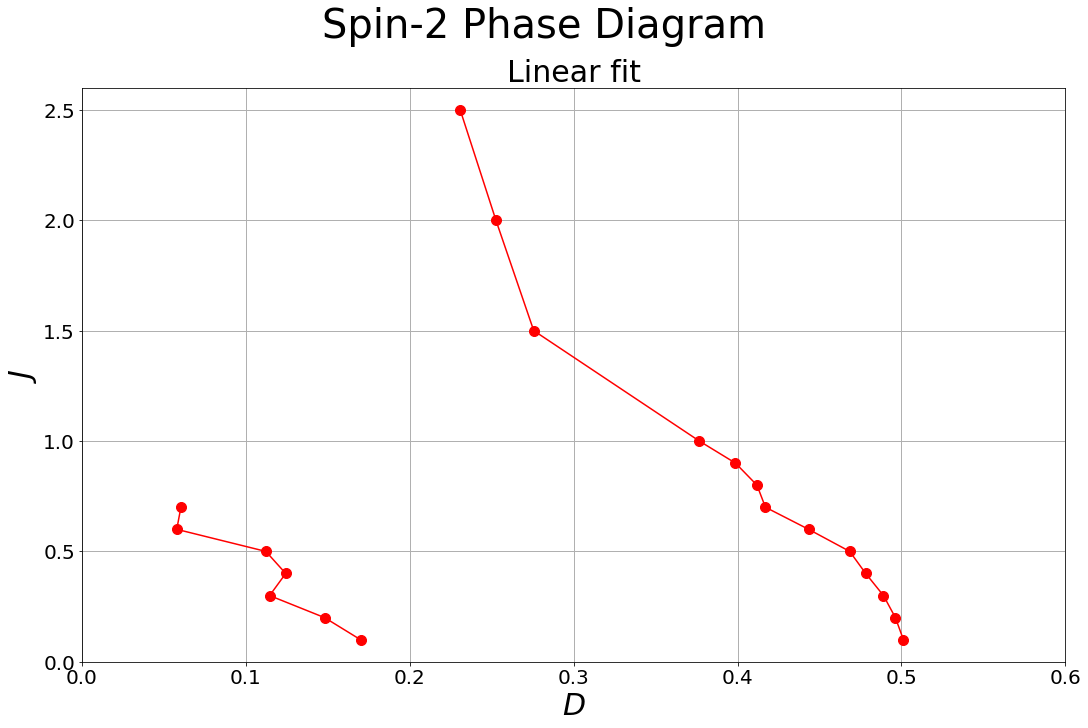

In [26]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(15,10))
## linear fit
ax.plot(PhaseDiagram_D1['D1'], PhaseDiagram_D1['J'], '-o', color="red", markersize = font_size/3)
ax.plot(PhaseDiagram_D2['D2'], PhaseDiagram_D2['J'], '-o', color="red", markersize = font_size/3)
ax.set_xlabel(r'$D$', fontsize=30)
ax.set_ylabel(r'$J$', fontsize=30)
ax.tick_params(axis='x', labelsize=20) 
ax.tick_params(axis='y', labelsize=20)
ax.set_title('Linear fit', fontsize=30)
ax.grid(linestyle='-', linewidth=1)
ax.set_xlim([0, 0.6])                  
ax.set_ylim([0, 2.6])          
# ax.legend(loc = 'best',fontsize=font_size*5/6)

fig.suptitle('Spin-2 Phase Diagram', fontsize=40)